In [1]:
import pandas as pd
import numpy as np

import pickle

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
train_home = pd.read_csv('Good_Shot_Feature/Home_Data_cleaned.csv', index_col=0)
train_away = pd.read_csv('Good_Shot_Feature/Away_Data_cleaned.csv', index_col=0)

In [3]:
def get_shot_sum_cols(cols):
    return [c for c in cols if ('sum' in c and 'GOALS' in c)], [c for c in cols if ('sum' in c and 'SHOT' in c)]

In [4]:
def get_training_test_shot(df):
    y_cols, x_cols = get_shot_sum_cols(df.columns)
    return df[y_cols[0]].copy(), df[x_cols[:5]].copy(), df[y_cols[1]].copy(), df[x_cols[5:]].copy()

In [5]:
y_home_s, X_home_s, y_home_5, X_home_5 = get_training_test_shot(train_home)
y_away_s, X_away_s, y_away_5, X_away_5 = get_training_test_shot(train_away)

## Fitting Models

Let us fit the first set of data

In [6]:
def get_poly_features(X,y, degree):
    poly = PolynomialFeatures(degree,include_bias = False)
    X_poly = poly.fit_transform(X)
    return train_test_split(X_poly, y, test_size=0.2, random_state=42) 

In [7]:
def fitting_goals_polynomial(X, y, degree = 1):
    X_train, X_test, y_train, y_test = get_poly_features(X,y, degree)
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train, y_train)
    print(f"R^2 train: {np.round(model.score(X_train, y_train),4)}; R^2 test: {np.round(model.score(X_test, y_test),4)}")
    print(f"MSE train: {np.round(mean_squared_error(model.predict(X_train), y_train),4)}; MSE test: {np.round(mean_squared_error(model.predict(X_test), y_test),4)}")
    print(f"{'-'*40}")
    return model

Lets first try a quad model

In [8]:
h_s = fitting_goals_polynomial(X_home_s, y_home_s, 2);
h_5 = fitting_goals_polynomial(X_home_5, y_home_5, 2);
a_s = fitting_goals_polynomial(X_away_s, y_away_s, 2);
a_5 = fitting_goals_polynomial(X_away_5, y_away_5, 2);

R^2 train: 0.5579; R^2 test: 0.5645
MSE train: 3.5876; MSE test: 3.5049
----------------------------------------
R^2 train: 0.3754; R^2 test: 0.3633
MSE train: 4.8847; MSE test: 5.0065
----------------------------------------
R^2 train: 0.5585; R^2 test: 0.5409
MSE train: 3.6121; MSE test: 3.6551
----------------------------------------
R^2 train: 0.371; R^2 test: 0.3696
MSE train: 5.0674; MSE test: 5.0556
----------------------------------------


Now lets try a linear model

In [9]:
h_s = fitting_goals_polynomial(X_home_s, y_home_s);
h_5 = fitting_goals_polynomial(X_home_5, y_home_5);
a_s = fitting_goals_polynomial(X_away_s, y_away_s);
a_5 = fitting_goals_polynomial(X_away_5, y_away_5);

R^2 train: 0.547; R^2 test: 0.551
MSE train: 3.676; MSE test: 3.6135
----------------------------------------
R^2 train: 0.371; R^2 test: 0.3564
MSE train: 4.9188; MSE test: 5.0608
----------------------------------------
R^2 train: 0.5463; R^2 test: 0.5317
MSE train: 3.7126; MSE test: 3.7289
----------------------------------------
R^2 train: 0.3665; R^2 test: 0.3669
MSE train: 5.1036; MSE test: 5.0772
----------------------------------------


It seems like a linear model works just as well, so we will use that in the future. This prediction seems to work well for the season, less well for the last 5 games. I think this is due to the larger statistical error in the measures, i.e. this data set will just be more noisy due to the lower sample size per metric. Two questions follow:

1. Can we use the same model for season away and home games?
2. If the answer to this is yes, can we use the same model for the last 5 games? i.e. is the last 5 games just too noisy to fit well. 

Let's start with 1. 

Mean Fractional Error: 0.0556


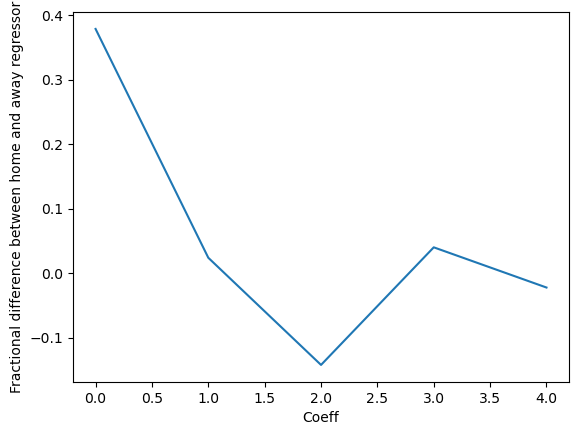

In [10]:
frac_coeff_diff = [abs(a-b)/a for a, b in zip(h_s.coef_, a_s.coef_)]
plt.plot(frac_coeff_diff)
print(f"Mean Fractional Error: {np.round(sum(frac_coeff_diff)/len(frac_coeff_diff),4)}")
plt.xlabel("Coeff")
plt.ylabel("Fractional difference between home and away regressor")
plt.show()

They seem to have similar coefficents. Lets see what the error is if we one model to predict the values of the other

In [11]:
print(f"R^2 train: {np.round(h_s.score(X_away_s, y_away_s),4)}")
print(f"MSE train: {np.round(mean_squared_error(h_s.predict(X_away_s), y_away_s),4)}") 
print(f"{'-'*40}")
print(f"R^2 train: {np.round(a_s.score(X_home_s, y_home_s),4)}")
print(f"MSE train: {np.round(mean_squared_error(a_s.predict(X_home_s), y_home_s),4)}") 
print(f"{'-'*40}")

R^2 train: 0.5432
MSE train: 3.7182
----------------------------------------
R^2 train: 0.5472
MSE train: 3.6683
----------------------------------------


i.e. they work well in prediciting each other. 

Now let's answer (2): does the home season model (and therefore  by extenstion the away season model) predict the last 5 score well?

In [13]:
print(f"R^2 train: {np.round(h_s.score(X_away_5, y_away_5),4)}")
print(f"MSE train: {np.round(mean_squared_error(h_s.predict(X_away_5), y_away_5),4)}") 
print(f"{'-'*40}")
print(f"R^2 train: {np.round(h_s.score(X_home_5, y_home_5),4)}")
print(f"MSE train: {np.round(mean_squared_error(h_s.predict(X_home_5), y_home_5),4)}") 
print(f"{'-'*40}")

R^2 train: 0.3454
MSE train: 5.2694
----------------------------------------
R^2 train: 0.3488
MSE train: 5.0986
----------------------------------------


Yes! The MSE error is only different by about .1. I guess this means that use the model trained on the season data to create a good shot metric.

Note the small $R^2$ due to the noise. 

Okay, so we will train the model on all the season data and then save the predictions to file. This can then be read into the exploration notebook and used as a param. 

In [14]:
X_home_s.columns = [c[5:] for c in X_home_s.columns]
X_away_s.columns = [c[5:] for c in X_away_s.columns]

In [15]:
X_total_s = pd.concat([X_home_s,X_away_s],join='inner',axis=0)
y_total_s = pd.concat([y_home_s,y_away_s],join='inner',axis=0)
X_total_s.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24606 entries, 0 to 12302
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   TEAM_SHOTS_TOTAL_season_sum       24606 non-null  float64
 1   TEAM_SHOTS_INSIDEBOX_season_sum   24606 non-null  float64
 2   TEAM_SHOTS_OFF_TARGET_season_sum  24606 non-null  float64
 3   TEAM_SHOTS_ON_TARGET_season_sum   24606 non-null  float64
 4   TEAM_SHOTS_OUTSIDEBOX_season_sum  24606 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB


In [16]:
total_model = fitting_goals_polynomial(X_total_s, y_total_s, degree = 1);

R^2 train: 0.5444; R^2 test: 0.5504
MSE train: 3.698; MSE test: 3.6577
----------------------------------------


In [17]:
column_title_s = "GOOD_SHOT_season_sum"
column_title_5 = "GOOD_SHOT_5_last_match_sum"

away_predict_s, home_predict_s = total_model.predict(X_away_s), total_model.predict(X_home_s)
away_predict_5, home_predict_5 = total_model.predict(X_away_5), total_model.predict(X_home_5)

save_df = pd.DataFrame({"AWAY_"+column_title_s : away_predict_s,
                       "HOME_"+column_title_s : home_predict_s,
                       "AWAY_"+column_title_5 : away_predict_5,
                       "HOME_"+column_title_5 : home_predict_5})

We will add the difference column to this: 

In [18]:
diff_predict_s = [h-a for h,a in zip(home_predict_s, away_predict_s)]
diff_predict_5 = [h-a for h,a in zip(home_predict_5, away_predict_5)]

save_df["DIFF_"+column_title_s] = diff_predict_s
save_df["DIFF_"+column_title_5] = diff_predict_5

save_df.head()

,AWAY_GOOD_SHOT_season_sum,HOME_GOOD_SHOT_season_sum,AWAY_GOOD_SHOT_5_last_match_sum,HOME_GOOD_SHOT_5_last_match_sum,DIFF_GOOD_SHOT_season_sum,DIFF_GOOD_SHOT_5_last_match_sum
0,1.306981,2.384875,1.741475,2.624344,1.077894,0.882868
1,2.640634,6.205935,3.128771,6.704377,3.565300,3.575606
2,2.266503,1.691464,1.432939,4.220691,-0.575039,2.787753
3,1.088272,5.221384,1.339505,3.823795,4.133112,2.484290
4,4.944519,3.240656,8.230155,3.588191,-1.703863,-4.641964


In [19]:
# Finally normalise this data to be between \in [0,10]
scaler = MinMaxScaler(feature_range = (0, 10)) # We want it to have the same range, but as a diff I want it to have mean 0

save_df = pd.DataFrame(scaler.fit_transform(save_df), columns = save_df.columns)
save_df.describe()

,AWAY_GOOD_SHOT_season_sum,HOME_GOOD_SHOT_season_sum,AWAY_GOOD_SHOT_5_last_match_sum,HOME_GOOD_SHOT_5_last_match_sum,DIFF_GOOD_SHOT_season_sum,DIFF_GOOD_SHOT_5_last_match_sum
count,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000,12303.000000
mean,4.510363,4.465209,4.396312,4.280394,4.977423,4.942041
std,1.858928,1.852388,1.827029,1.802272,1.269583,1.257391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.055098,3.016769,2.983697,2.895007,4.170784,4.121428
50%,4.250752,4.206527,4.170155,4.058418,4.974646,4.943189
75%,5.782954,5.730730,5.588104,5.441823,5.782007,5.740440
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [21]:
save_df.to_csv('Good_Shot_Feature/training_good_shot_feature.csv', index = False)

with open('Good_Shot_Feature/good_shot_model.pkl', 'wb') as f:
    pickle.dump(total_model, f)